In [94]:
import pandas as pd

UNKNOWN = 'unknown'

In [95]:
# Read in the data from the CSV file into a a dataframe 
df = pd.read_csv('coded_log.csv', sep=";",names=['userId', '1?', 'date','eventType','application','2?','ip','3?','4?','5?'])

In [96]:
# Visualize a snippet of the data frame df
df.head(10)

,userId,1?,date,eventType,application,2?,ip,3?,4?,5?
0,1,10036,2021-05-11 18:48:34.000,1,HRW,NaN,NaN,xxx,,o8zeb75bwa
1,1,64429,2021-04-17 12:04:05.000,1,HRW,NaN,NaN,xxx,,gud00usqus
2,1,78248,2021-05-16 00:04:05.000,1,HRW,NaN,NaN,xxx,,dl5ncrxi13
3,1,148583,2021-06-19 21:32:23.000,1,HRW,NaN,NaN,xxx,,j9m8itiaka
4,1,180593,2021-03-29 15:03:36.000,1,HRW,NaN,NaN,xxx,,r3649bgcxn
5,1,436612,2021-03-23 15:04:01.000,1,HRW,NaN,NaN,xxx,,q2xposd8fx
6,1,478900,2021-04-30 08:34:03.000,1,HRW,NaN,NaN,xxx,,squqm84joa
7,1,562910,2021-06-25 08:01:30.000,1,HRW,NaN,NaN,xxx,,cx4iagls3j
8,1,563290,2021-06-02 10:46:15.000,1,HRW,NaN,NaN,xxx,,ow1gzqachr
9,1,613000,2021-05-17 20:20:27.000,1,HRW,NaN,NaN,xxx,,zj66xzdnj6


In [97]:
#remove unkown coloums
df_ = df.drop(columns=['1?','2?','3?','4?','5?'])

df_.head(10)

,userId,date,eventType,application,ip
0,1,2021-05-11 18:48:34.000,1,HRW,NaN
1,1,2021-04-17 12:04:05.000,1,HRW,NaN
2,1,2021-05-16 00:04:05.000,1,HRW,NaN
3,1,2021-06-19 21:32:23.000,1,HRW,NaN
4,1,2021-03-29 15:03:36.000,1,HRW,NaN
5,1,2021-03-23 15:04:01.000,1,HRW,NaN
6,1,2021-04-30 08:34:03.000,1,HRW,NaN
7,1,2021-06-25 08:01:30.000,1,HRW,NaN
8,1,2021-06-02 10:46:15.000,1,HRW,NaN
9,1,2021-05-17 20:20:27.000,1,HRW,NaN


In [98]:
#cleaning row data

print('number of null entries:')
df_.isnull().sum()

number of null entries:


userId              0
date                0
eventType           0
application         0
ip             339741
dtype: int64

In [99]:
df_['ip'].fillna(UNKNOWN,inplace=True)

df_.head(10)

,userId,date,eventType,application,ip
0,1,2021-05-11 18:48:34.000,1,HRW,unknown
1,1,2021-04-17 12:04:05.000,1,HRW,unknown
2,1,2021-05-16 00:04:05.000,1,HRW,unknown
3,1,2021-06-19 21:32:23.000,1,HRW,unknown
4,1,2021-03-29 15:03:36.000,1,HRW,unknown
5,1,2021-03-23 15:04:01.000,1,HRW,unknown
6,1,2021-04-30 08:34:03.000,1,HRW,unknown
7,1,2021-06-25 08:01:30.000,1,HRW,unknown
8,1,2021-06-02 10:46:15.000,1,HRW,unknown
9,1,2021-05-17 20:20:27.000,1,HRW,unknown


In [100]:
#DATA CLEANING 

df_['date'] = pd.to_datetime(df_['date'], format="%Y-%m-%d %H:%M:%S.%f")
df_.sort_values(by="date",ascending=True,inplace=True)

#check data consistency delete rows containing non-valid event code
df_ = df_[(df_.eventType >= 1) & (df_.eventType <= 3)]

#check data rendundancy
duplicates = df_.duplicated().sum()
if(duplicates > 0):
    print(f'Duplicates number {duplicates} on {len(df_.index)}')
    df_.drop_duplicates(inplace = True)
    print(f'New size:{len(df_.index)}')
df_

Duplicates number 3432 on 849552
New size:846120


,userId,date,eventType,application,ip
627467,25781,2019-11-22 21:14:28,2,ERM,ip_30498
627466,25781,2019-11-22 21:17:09,2,ERM,ip_30498
627470,25781,2019-11-22 21:21:38,2,ERM,ip_30498
643121,26401,2019-11-23 05:40:12,2,ERM,ip_25478
643129,26401,2019-11-23 06:20:56,1,ERM,ip_25478
...,...,...,...,...,...
580741,24203,2021-06-28 16:29:12,2,ERM,ip_1099
474892,20134,2021-06-28 16:29:13,1,HRW,unknown
321035,13237,2021-06-28 16:29:16,1,ERM,ip_126
809559,32639,2021-06-28 16:29:17,1,ERM,ip_42700


<h3>Numerosity reduction</h3>

In [101]:
# counting unique values
userIdNumber = len(pd.unique(df_['userId']))
userIdNumber

18080

In [102]:
# Need to reduce the numerosity of userId 1
df_user1 = df_[df_.userId == 1]
df_user1

,userId,date,eventType,application,ip
9162,1,2021-03-22 20:03:59,1,HRW,unknown
5482,1,2021-03-22 20:18:59,1,HRW,unknown
1872,1,2021-03-22 20:33:59,1,HRW,unknown
8919,1,2021-03-22 20:48:59,1,HRW,unknown
3704,1,2021-03-22 21:03:59,1,HRW,unknown
...,...,...,...,...,...
6216,1,2021-06-28 15:16:25,1,HRW,unknown
4239,1,2021-06-28 15:31:25,1,HRW,unknown
2170,1,2021-06-28 15:46:25,1,HRW,unknown
9069,1,2021-06-28 16:01:25,1,HRW,unknown


In [103]:
df_.groupby('eventType').eventType.count()

eventType
1    628356
2     92058
3    125706
Name: eventType, dtype: int64

<h3>Login dataframe</h3>

In [104]:
# constants

START_WORKING = 8
END_WORKING = 19

In [105]:
# lambda functions

isWorkingTime = lambda x: x.isoweekday() in range(1,5) and x.to_pydatetime().hour >= START_WORKING and x.to_pydatetime().hour <= END_WORKING

# toDay: convert a stirng representing a date into a number 
#    1 --> Monday
#    2 --> Tuesday
#    ...
#    7 --> Sunday
toDay = lambda x: x.isoweekday() 


In [106]:
#setting up the 1st datase
df_logins = pd.DataFrame(columns=['userId', 'date', 'day', 'workingTime', 'eventType', 'application'])
df_logins['userId'] = df_['userId']
df_logins['date'] = df_["date"]
df_logins['day'] = df_logins['date'].apply(toDay)
df_logins['workingTime'] = df_logins['date'].apply(isWorkingTime)
df_logins['eventType'] = df_['eventType']
df_logins['application'] = df_['application']

df_logins

,userId,date,day,workingTime,eventType,application
627467,25781,2019-11-22 21:14:28,5,False,2,ERM
627466,25781,2019-11-22 21:17:09,5,False,2,ERM
627470,25781,2019-11-22 21:21:38,5,False,2,ERM
643121,26401,2019-11-23 05:40:12,6,False,2,ERM
643129,26401,2019-11-23 06:20:56,6,False,1,ERM
...,...,...,...,...,...,...
580741,24203,2021-06-28 16:29:12,1,True,2,ERM
474892,20134,2021-06-28 16:29:13,1,True,1,HRW
321035,13237,2021-06-28 16:29:16,1,True,1,ERM
809559,32639,2021-06-28 16:29:17,1,True,1,ERM


In [107]:
df_logins.groupby('day').day.count()

day
1    177305
2    160928
3    147704
4    160551
5    154631
6     25318
7     19683
Name: day, dtype: int64

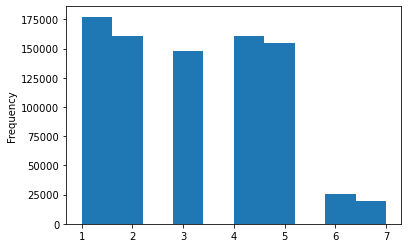

In [108]:
import matplotlib.pyplot as plt

# number of event per day
df_logins['day'].plot.hist()
plt.show()


In [132]:
# group by the userId
df_groupbyUserId = df_.groupby('userId')

users_id = []
for key, value in df_groupbyUserId:
    users_id.append(key)
# user_id - value 
usersdIpAmount = df_groupbyUserId["ip"].nunique()
# user_id - value
failedAttemps = {}
successAttemps = {}
logoutAmount = {}
avgLoginLogout = {}
avgTimeBtwLogin = {}
for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    
    ctr = user_group[user_group["eventType"] == 2].count()
    failedAttemps[i] = ctr["eventType"]
    ctr = user_group[user_group["eventType"] == 1].count()
    successAttemps[i] = ctr["eventType"]
    ctr = user_group[user_group["eventType"] == 3].count()
    logoutAmount[i] = ctr["eventType"]
    
#avarage loginLogout 
for key,value in successAttemps.items():
    avgLoginLogout[key] = 0 if(key not in logoutAmount or logoutAmount[key] == 0 ) else  value/logoutAmount[key]
    
# avarage time between two consecutive login
from datetime import datetime
avgTimeBtwLogin = {}
for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    delta_sum = 0
    rowsNumber = len(user_group.index)
    for j in range(rowsNumber - 1):
        # pd.Timedelta(t2 - t1).seconds / 3600.0
        delta_sum += (user_group.iloc[j+1]["date"] - user_group.iloc[j]["date"]).total_seconds() * 1000
    
    avgTimeBtwLogin[i] = int(delta_sum/rowsNumber)

    

In [133]:
# setting up 2nd dataset
df_users = pd.DataFrame(columns=["userId","usedIpAmount","avgTimeBtwLogin",
                                 "failedAttemps","successAttemps","logoutAmount","avgLoginLogout"])
df_users["userId"] = users_id
df_users["usedIpAmount"] = usersdIpAmount
df_users["failedAttemps"] = failedAttemps.values()
df_users["successAttemps"] = successAttemps.values()
df_users["logoutAmount"] = logoutAmount.values()
df_users["avgLoginLogout"] = avgLoginLogout.values()
df_users["avgTimeBtwLogin"] = avgTimeBtwLogin.values()

df_users

,userId,usedIpAmount,avgTimeBtwLogin,failedAttemps,successAttemps,logoutAmount,avgLoginLogout
0,1,NaN,873480,1,9677,0,0.000000
1,10,2.0,6128292500,2,0,0,0.000000
2,17,NaN,413828111,9,9,0,0.000000
3,18,NaN,11000,4,0,0,0.000000
4,21,NaN,159858208,2,28,18,1.555556
...,...,...,...,...,...,...,...
18075,33952,NaN,0,0,1,0,0.000000
18076,33953,NaN,0,0,1,0,0.000000
18077,33954,NaN,0,0,1,0,0.000000
18078,33961,NaN,0,0,1,0,0.000000
